In [30]:
import os 
import networkx as nx
import random
import itertools
import glob
import time
import matplotlib.pyplot as plt


file_path = os.path.join("..", "data", "facebook.tar.gz")
data_path = os.path.join("..", "data", "facebook")


def initialize_graph(path, graph):
    # Read the edges from the file
    with open(path, "r") as edges_file:
        for line in edges_file:
            edge = line.strip().split()
            graph.add_edge(edge[0], edge[1])
    return graph

class StreamingTriangles:
    def __init__(self, se, sw):
        self.edge_reservoir = []
        self.wedge_reservoir = []
        self.is_closed = [False] * sw
        self.tot_wedges = 0
        self.current_edge_count = 0

        self.se = se
        self.sw = sw

    def get_edges(self, filename):
        with open(os.path.join(filename), "r") as edges_file:
            return [tuple(line.strip().split()) for line in edges_file]

    def initialize_edge_reservoir(self, initial_edges):
        # Take the first 'se' edges from the stream
        for edge in initial_edges[:self.se]:
            self.edge_reservoir.append(edge)

    def initialize_wedge_reservoir(self):
        # Generate wedges from the initial edge reservoir
        all_possible_wedges = itertools.combinations(self.edge_reservoir, 2)
        for edge1, edge2 in all_possible_wedges:
            if len(set(edge1) & set(edge2)) == 1:
                # This is a valid wedge
                new_wedge = tuple(set(edge1) | set(edge2))
                if len(self.wedge_reservoir) < self.sw:
                    self.wedge_reservoir.append(new_wedge)

    def update(self, et):
        # Increment the current edge count
        self.current_edge_count += 1

        # Populate the edge reservoir if it's not full
        if len(self.edge_reservoir) < self.se:
            self.edge_reservoir.append(et)
        else:
            # Perform reservoir sampling for edge reservoir
            self.reservoir_sampling_on_edge_reservoir(et)

        # Compute potential new wedges formed by this edge
        new_wedges = self.compute_Nt(et)

        # Populate the wedge reservoir if it's not full
        if len(self.wedge_reservoir) < self.sw:
            for w in new_wedges:
                if len(self.wedge_reservoir) < self.sw:
                    self.wedge_reservoir.append(w)
                    self.is_closed.append(False)  # Initial status of the new wedge
                else:
                    break
        else:
            # Perform reservoir sampling for wedge reservoir
            self.reservoir_sampling_on_wedge_reservoir(new_wedges)

        # Update the total wedges count
        self.tot_wedges = self.compute_tot_wedges()

        # Check and update closed wedges
        self.update_closed_wedges(et)


    def reservoir_sampling_on_edge_reservoir(self, et):
        updated = False
        for i in range(self.se):
            x = random.uniform(0, 1)
            if x <= self.se / self.current_edge_count:
                if i < len(self.edge_reservoir):
                    self.edge_reservoir[i] = et
                    updated = True
        return updated  # This will indicate if an update occurred

    def update_closed_wedges(self, et):
        for i in range(len(self.wedge_reservoir)):
            if self.is_closed[i]:
                continue
            if self.closed_by_edge(self.wedge_reservoir[i], et):
                self.is_closed[i] = True

    def closed_by_edge(self, wedge, edge):
        if edge[0] == wedge[0] and edge[1] == wedge[2]:
            return True
        else:
            return False
        
    def compute_Nt(self, et):
        u, v = et
        G = nx.Graph()
        G.add_edges_from(self.edge_reservoir)

        # Ensure nodes exist in the graph
        if u not in G:
            G.add_node(u)
        if v not in G:
            G.add_node(v)

        # Get neighbors of u and v in the graph
        neighbors_u = set(G.neighbors(u))
        neighbors_v = set(G.neighbors(v))

        # Generate all wedges involving et using neighbors of u and v
        new_wedges = [(u, v, w) for w in neighbors_u.intersection(neighbors_v)]
        return new_wedges

    def estimate_triangles(self):
        closed_wedges = sum(self.is_closed)
        rho = closed_wedges / self.sw
        kt = 3 * rho
        t_squared = self.current_edge_count ** 2
        estimated_triangles = (rho * t_squared / (self.se * (self.se - 1))) * self.tot_wedges
        return estimated_triangles, kt

    def compute_tot_wedges(self):
        return sum(1 for closed in self.is_closed if closed == False)


    def reservoir_sampling_on_wedge_reservoir(self, new_wedges):
        # Ensure that self.wedge_reservoir has been pre-initialized to the correct size.
        # For example, in the __init__ method, you could use:
        # self.wedge_reservoir = [None] * self.sw
        
        for i in range(self.sw):
            x = random.uniform(0, 1)
            if len(new_wedges) == 0:
                # Handle the case when there are no new wedges to sample from
                break
            
            if self.tot_wedges == 0 or x <= len(new_wedges) / self.tot_wedges:
                # Choose a random new wedge to add to the reservoir
                w = random.choice(new_wedges)
                
                # Check if the wedge reservoir already has an element at index i
                if i < len(self.wedge_reservoir):
                    self.wedge_reservoir[i] = w
                else:
                    # If not, append the new wedge
                    self.wedge_reservoir.append(w)
                
                # Reset the is_closed flag for the new wedge
                if i < len(self.is_closed):
                    self.is_closed[i] = False
                else:
                    # If not, append the False value
                    self.is_closed.append(False)


    def is_closed_wedge(self, wedge):
        # Pseudo-function, replace with actual logic to check if a wedge is closed
        return any(w.closed_by_edge(et) for w in wedge)

    def initialize_reservoirs(self, initial_graph):
        self.initialize_edge_reservoir(initial_graph)
        self.initialize_wedge_reservoir()

    def get_initial_elements(self, filename):
        elems = nx.Graph()
        with open(os.path.join(data_path, filename), "r") as edges_file:
            for line in edges_file:
                edge = line.strip().split()
                elems.add_edge(edge[0], edge[1])
        return elems
    
    def compute_wedge_reservoir(self):
        cliques = list(nx.enumerate_all_cliques(self.edge_reservoir))
        wedges_res = [clique for clique in cliques if len(clique) == 3]
        return wedges_res



Processing ..\data\facebook\0.edges
Processed ..\data\facebook\0.edges in 0.4701 seconds
Estimated number of triangles: 2837.252325925926
Estimated transitivity (clustering coefficient): 0.02
Triangle error: 0.9982399288305123
Coefficient error: 0.9669694467382328
Processing ..\data\facebook\107.edges
Processed ..\data\facebook\107.edges in 5.8677 seconds
Estimated number of triangles: 4873192.243199999
Estimated transitivity (clustering coefficient): 0.22
Triangle error: 0.6692086173597231
Coefficient error: 0.6366639141205616
Processing ..\data\facebook\1684.edges
Processed ..\data\facebook\1684.edges in 3.2308 seconds
Estimated number of triangles: 23535374.127321217
Estimated transitivity (clustering coefficient): 0.42000000000000004
Triangle error: 0.931506931171802
Coefficient error: 0.30635838150289013
Processing ..\data\facebook\1912.edges
Processed ..\data\facebook\1912.edges in 7.4191 seconds
Estimated number of triangles: 127575744.4056
Estimated transitivity (clustering coe

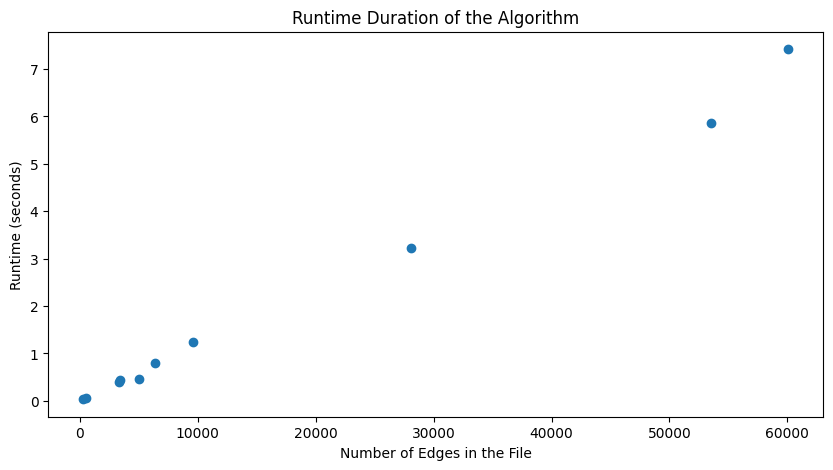

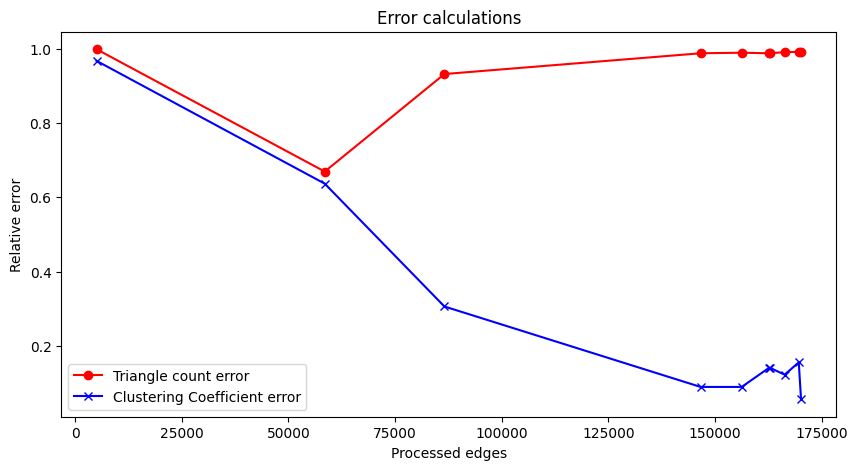

Estimated number of triangles: 167241761.48617914
Estimated transitivity (clustering coefficient): 0.64
Sample edges from edge reservoir: [('591', '641'), ('719', '815'), ('842', '713'), ('805', '756'), ('724', '820')]
Sample wedges from wedge reservoir: [('834', '853', '706'), ('745', '828', '815'), ('3613', '3594', '3883'), ('752', '828', '842'), ('141', '26', '280')]


In [35]:
# Initialize the StreamingTriangles instance
se, sw = 10000, 15000

actual_triangles =	1612010
actual_coefficient = 0.6055

print(f"Edge reservoir size: {se}, Wedge reservoir size: {sw}")
st = StreamingTriangles(se=se, sw=sw)

# Process all edges from the stream
def process_all_edges(directory):
    file_sizes = []  # List to hold the number of edges in each file
    run_times = []   # List to hold the run time for each file
    triangle_errors = []
    coefficient_errors = []
    processed_edges = []
    edges_processed = 0

    for filename in glob.glob(os.path.join(directory, '*.edges')):
        print(f"Processing {filename}")
        start_time = time.time()  # Start time before processing the file
        new_edges = st.get_edges(filename)
        for edge in new_edges:
            st.update(edge)
        end_time = time.time()  # End time after processing the file
        run_time = end_time - start_time
        run_times.append(run_time)

        edges_processed += len(new_edges)
        processed_edges.append(edges_processed)
        file_sizes.append(len(new_edges))

        estimated_triangles, kt = st.estimate_triangles()
        # Calculate errors
        triangle_error = abs(estimated_triangles - actual_triangles) / max(actual_triangles, estimated_triangles)
        coefficient_error = abs(kt - actual_coefficient) / actual_coefficient

        # Store errors
        triangle_errors.append(triangle_error)
        coefficient_errors.append(coefficient_error)
        
        print(f"Edge reservoir size: {se}, Wedge reservoir size: {sw}")
        print(f"Processed {filename} in {run_time:.4f} seconds")
        print(f"Estimated number of triangles: {estimated_triangles}")
        print(f"Estimated transitivity (clustering coefficient): {kt}")
        print(f"Triangle error: {triangle_error}")
        print(f"Coefficient error: {coefficient_error}")
    
        # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(file_sizes, run_times, marker='o')
    plt.title('Runtime Duration of the Algorithm')
    plt.xlabel('Number of Edges in the File')
    plt.ylabel('Runtime (seconds)')

    plt.figure(figsize=(10, 5))
    plt.plot(processed_edges, triangle_errors, marker = "o", color="red", label="Triangle count error")
    plt.plot(processed_edges, coefficient_errors, marker = "x", color='blue', label="Clustering Coefficient error")
    plt.legend()
    plt.title('Error calculations')
    plt.xlabel('Processed edges')
    plt.ylabel('Relative error')
    plt.show()

# Example usage
process_all_edges(data_path)

estimated_triangles, kt = st.estimate_triangles()
print(f"Estimated number of triangles: {estimated_triangles}")
print(f"Estimated transitivity (clustering coefficient): {kt}")
print("Sample edges from edge reservoir:", st.edge_reservoir[:5])  # print first 5 for example
print("Sample wedges from wedge reservoir:", st.wedge_reservoir[:5])  # print first 5 for example

# If you have a method to estimate the total number of triangles, call it here
# print("Estimated total number of triangles:", st.estimate_total_triangles())
